In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import minimize_scalar

import matplotlib as mpl
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rcParams['savefig.dpi'] = 1200
mpl.rcParams['text.usetex'] = True  # not really needed

np.random.seed(1000)

## Data & Settings

In [3]:
def get_isotropic_data(n, p, beta, sigma):
    X = np.random.randn(n, p)
    Y = X @ beta + sigma * np.random.randn(n, 1)
    
    return X, Y

def excess_risk_isotropic_cov(beta_hat, beta):
    return np.linalg.norm(beta_hat - beta) ** 2

def get_mse(X, Y, beta):
    err = (X @ beta - Y)**2
    return np.mean(err)

## Setting (i): covariate shift

In [4]:
def get_covariate_shifted_data(n1, n2, p, beta_1, beta_2, sigma, scale=4):
    
    s_diag = scale * np.ones(p)
    for i in range(int(p/2), p):
        s_diag[i] = s_diag[i] / scale**2

    X2 = np.random.randn(n2, p)
    Y2 = X2 @ beta_2 + sigma * np.random.randn(n2, 1)
    
    X1 = np.random.randn(n1, p) @ np.diag(s_diag)
    Y1 = X1 @ beta_1 + sigma * np.random.randn(n1, 1)
    
    return X1, Y1, X2, Y2

## Estimators

In [5]:
def get_HPS_estimator(X1, Y1, X2, Y2):
    K = np.linalg.inv(X1.T @ X1 + X2.T @ X2)
    
    return K @ (X1.T @ Y1 + X2.T @ Y2)

def get_avg_estimator_optimized(X1, Y1, X2, Y2, X2_val, Y2_val):
    opt_risk = 10000
    opt_b = 0
    
    beta_1_ols = np.linalg.inv(X1.T @ X1) @ X1.T @ Y1
    beta_2_ols = np.linalg.inv(X2.T @ X2) @ X2.T @ Y2
    
    for i in range(0, 101):
        b = 0.01 * i
        estimator = b * beta_1_ols + (1 - b) * beta_2_ols
        risk = get_mse(X2_val, Y2_val, estimator)
        if risk < opt_risk:
            opt_risk = risk
            opt_b = b
            
#    print(opt_b)
    return opt_b * beta_1_ols + (1 - opt_b) * beta_2_ols


def get_STL_estimator(X2, Y2):
    return np.linalg.inv(X2.T @ X2) @ X2.T @ Y2


def get_TL_estimator(X1, Y1):
    return np.linalg.inv(X1.T @ X1) @ X1.T @ Y1


def get_ridge_estimator_optimized(X2, Y2, X2_val, Y2_val, p):
    opt_risk = 10000
    opt_b = 0
    for i in range(0, 101):
        b = 0.4 * i
        estimator = np.linalg.inv(X2.T @ X2 + b * np.eye(p)) @ X2.T @ Y2
        risk = get_mse(X2_val, Y2_val, estimator)
        if risk < opt_risk:
            opt_risk = risk
            opt_b = b
            
#    print(opt_b)
    return np.linalg.inv(X2.T @ X2 + opt_b * np.eye(p)) @ X2.T @ Y2


def get_HPS_estimator_optimized(X1, Y1, X2, Y2, X2_val, Y2_val, p):
    opt_risk = 10000
    opt_b = 0
    opt_estimator = None
    
    for i in range(0, 101):
        b = 0.01 * i
        K_b = np.linalg.inv(b * X1.T @ X1 + (1 - b) * X2.T @ X2)
        estimator = K_b @ (b * X1.T @ Y1 + (1 - b) * X2.T @ Y2)
        risk = get_mse(X2_val, Y2_val, estimator)
        if risk < opt_risk:
            opt_risk = risk
            opt_b = b
            opt_estimator = estimator

    opt_br = 0
    for i in range(0, 101):
        br = 0.4 * i
        K_br = np.linalg.inv(opt_b * X1.T @ X1 + (1 - opt_b) * X2.T @ X2 + br * np.eye(p))
        estimator = K_br @ (opt_b * X1.T @ Y1 + (1 - opt_b) * X2.T @ Y2)
        risk = get_mse(X2_val, Y2_val, estimator)
#        print(br, risk, opt_risk, np.linalg.norm(estimator - opt_estimator))
        if risk < opt_risk:
            opt_risk = risk
            opt_br = br
            opt_estimator = estimator
    
#    print(opt_b, opt_br)
    return opt_estimator

## Covariate shift experiments

In [6]:
def run_covariate_shift(n1, n2, p, sigma, shift_scale, num_seeds = 3):
    HPS_rand = []
    AVG_rand = []
    STL_rand = []
    TL_rand = []
    ridge_rand = []
    
    for i in range(num_seeds):
        beta = np.random.randn(p, 1) / math.sqrt(p)
        X1, Y1, X2, Y2 = get_covariate_shifted_data(n1, n2, p, beta, beta, sigma, shift_scale)
        X2_val, Y2_val = get_isotropic_data(n2, p, beta, sigma)

        HPS_estimator = get_HPS_estimator_optimized(X1, Y1, X2, Y2, X2_val, Y2_val, p)
        HPS_risk = excess_risk_isotropic_cov(HPS_estimator, beta)
        HPS_rand.append(HPS_risk)

        AVG_estimator = get_avg_estimator_optimized(X1, Y1, X2, Y2, X2_val, Y2_val)
        AVG_risk = excess_risk_isotropic_cov(AVG_estimator, beta)
        AVG_rand.append(AVG_risk)

        STL_estimator = get_STL_estimator(X2, Y2)
        STL_risk = excess_risk_isotropic_cov(STL_estimator, beta)
        STL_rand.append(STL_risk)
        
        TL_estimator = get_TL_estimator(X1, Y1)
        TL_risk = excess_risk_isotropic_cov(TL_estimator, beta)
        TL_rand.append(TL_risk)
        
        ridge_estimator = get_ridge_estimator_optimized(X2, Y2, X2_val, Y2_val, p)
        ridge_risk = excess_risk_isotropic_cov(ridge_estimator, beta)
        ridge_rand.append(ridge_risk)
    
    return HPS_rand, AVG_rand, STL_rand, TL_rand, ridge_rand

p = 50
n1 = 100
n2 = 100
sigma = 0.5

shift_list = [i / 5.0 for i in range(1, 51)]
HPS_list = []
AVG_list = []
STL_list = []
TL_list = []
RIDGE_list = []

i = 0
for shift_scale in shift_list:
    print(i); i = i + 1
    HPS_rand, AVG_rand, STL_rand, TL_rand, ridge_rand = run_covariate_shift(n1, n2, p, sigma, shift_scale, 500)
    HPS_list.append(HPS_rand)
    AVG_list.append(AVG_rand)
    STL_list.append(STL_rand)
    TL_list.append(TL_rand)
    RIDGE_list.append(ridge_rand)

#    print(HPS_risk, AVG_risk)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


## Plotting

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


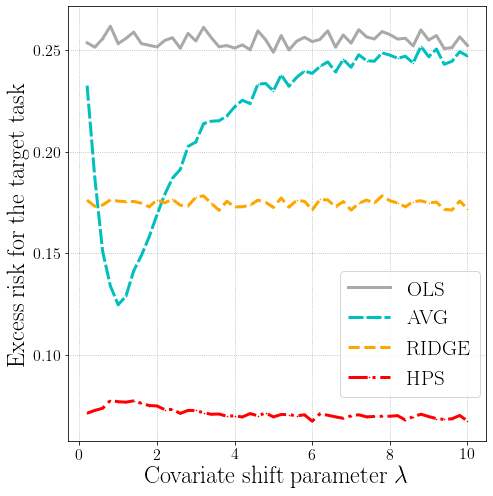

In [13]:
plt.figure(figsize=(7,7))

mean_stl = [np.mean(x) for x in STL_list]
std_stl = [np.std(x) for x in STL_list]
plt.errorbar(shift_list, mean_stl, capthick=1, capsize=5, c='darkgrey', lw=3, marker='x', markersize=1,  label=r'$\mathrm{OLS}$')


mean_avg = [np.mean(x) for x in AVG_list]
std_avg = [np.std(x) for x in AVG_list]
plt.errorbar(shift_list, mean_avg, capthick=1, capsize=5, c='c', lw=3, ls=(0, (5, 1)), marker='x', markersize=1,  label=r'$\mathrm{AVG}$')


mean_ridge = [np.mean(x) for x in RIDGE_list]
std_ridge = [np.std(x) for x in RIDGE_list]
plt.errorbar(shift_list, mean_ridge, capthick=1, capsize=5, c='orange', lw=3, ls='dashed', marker='x', markersize=1,  label=r'$\mathrm{RIDGE}$')



mean_hps = [np.mean(x) for x in HPS_list]
std_hps = [np.std(x) for x in HPS_list]
plt.errorbar(shift_list, mean_hps, capthick=1, capsize=5, c='r', lw=3, ls='dashdot', marker='x', markersize=1,  label=r'$\mathrm{HPS}$')

#mean_tl = [np.mean(x) for x in TL_list]
#std_tl = [np.std(x) for x in TL_list]
#plt.errorbar(shift_list, mean_tl, yerr=std_tl, capthick=1, capsize=1, c='g', lw=1, marker='x', markersize=1,  label='TL')


plt.xlabel(r'$\mathrm{Covariate~shift~parameter}~\lambda$', fontsize=24)
plt.ylabel(r'$\mathrm{Excess~risk~for~the~target~task}$', fontsize=24)
#axes = plt.gca()
#axes.set_xlim([1.0, 20.0])

plt.yticks(np.arange(0.1, 0.3, 0.05), fontsize=16)
plt.xticks(np.arange(0.0, 11, 2), fontsize=16)
#plt.xlim([500, 4000])
#plt.ylim([0.01, 2])

plt.grid(ls = ':', lw=0.8)
plt.legend(fontsize=21, loc=(0.65, 0.1))
plt.tight_layout()
plt.savefig('compare_risk_covariate_shift.eps')

## Model shift experiments

In [8]:
def run_model_shift(n1, n2, p, sigma, d, num_seeds = 3):
    HPS_rand = []
    AVG_rand = []
    STL_rand = []
    TL_rand = []    
    ridge_rand = []
    
    for i in range(num_seeds):
        beta_2 = np.random.randn(p, 1) / math.sqrt(p)
        beta_1 = beta_2 + d * np.random.randn(p, 1)
        
        X1, Y1 = get_isotropic_data(n1, p, beta_1, sigma)
        X2, Y2 = get_isotropic_data(n2, p, beta_2, sigma)
        X2_val, Y2_val = get_isotropic_data(n2, p, beta_2, 0)

        HPS_estimator = get_HPS_estimator_optimized(X1, Y1, X2, Y2, X2_val, Y2_val, p)
        HPS_risk = excess_risk_isotropic_cov(HPS_estimator, beta_2)
        HPS_rand.append(HPS_risk)

        AVG_estimator = get_avg_estimator_optimized(X1, Y1, X2, Y2, X2_val, Y2_val)
        AVG_risk = excess_risk_isotropic_cov(AVG_estimator, beta_2)
        AVG_rand.append(AVG_risk)
        
        STL_estimator = get_STL_estimator(X2, Y2)
        STL_risk = excess_risk_isotropic_cov(STL_estimator, beta_2)
        STL_rand.append(STL_risk)
        
        TL_estimator = get_TL_estimator(X1, Y1)
        TL_risk = excess_risk_isotropic_cov(TL_estimator, beta_2)
        TL_rand.append(TL_risk)

        ridge_estimator = get_ridge_estimator_optimized(X2, Y2, X2_val, Y2_val, p)
        ridge_risk = excess_risk_isotropic_cov(ridge_estimator, beta_2)
        ridge_rand.append(ridge_risk)
        
        
    return HPS_rand, AVG_rand, STL_rand, TL_rand, ridge_rand


p = 50
n1 = 100
n2 = 100
sigma = 0.5

shift_list1 = [i * 0.01 for i in range(0, 41)]
HPS_list1 = []
AVG_list1 = []
STL_list1 = []
TL_list1 = []
RIDGE_list1 = []

for shift_scale in shift_list1:
    print(i); i = i + 1    
    HPS_rand1, AVG_rand1, STL_rand1, TL_rand1, ridge_rand1 = run_model_shift(n1, n2, p, sigma, shift_scale, 500)
    HPS_list1.append(HPS_rand1)
    AVG_list1.append(AVG_rand1)
    STL_list1.append(STL_rand1)
    TL_list1.append(TL_rand1)
    RIDGE_list1.append(ridge_rand1)


50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


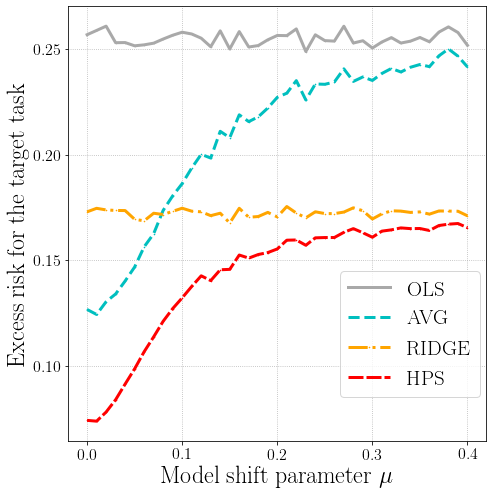

In [14]:
plt.figure(figsize=(7,7))

mean_stl1 = [np.mean(x) for x in STL_list1]
std_stl1 = [np.std(x) for x in STL_list1]
plt.errorbar(shift_list1, mean_stl1, capthick=1, capsize=5, c='darkgrey', lw=3, marker='x', markersize=1,  label=r'$\mathrm{OLS}$')


mean_avg1 = [np.mean(x) for x in AVG_list1]
std_avg1 = [np.std(x) for x in AVG_list1]
plt.errorbar(shift_list1, mean_avg1, capthick=1, capsize=5, c='c', lw=3, ls='dashed', marker='x', markersize=1,  label=r'$\mathrm{AVG}$')

mean_ridge1 = [np.mean(x) for x in RIDGE_list1]
std_ridge1 = [np.std(x) for x in RIDGE_list1]
plt.errorbar(shift_list1, mean_ridge1, capthick=1, capsize=5, c='orange', lw=3, ls='dashdot', marker='x', markersize=1, label=r'$\mathrm{RIDGE}$')



mean_hps1 = [np.mean(x) for x in HPS_list1]
std_hps1 = [np.std(x) for x in HPS_list1]
plt.errorbar(shift_list1, mean_hps1, capthick=1, capsize=5, c='r', lw=3, ls=(0, (5, 1)),  marker='x', markersize=1,  label=r'$\mathrm{HPS}$')

#mean_tl = [np.mean(x) for x in TL_list]
#std_tl = [np.std(x) for x in TL_list]
#plt.errorbar(shift_list, mean_tl, yerr=std_tl, capthick=1, capsize=1, c='g', lw=1, marker='x', markersize=1,  label='TL')


plt.xlabel(r'$\mathrm{Model~shift~parameter}~\mu$', fontsize=24)
plt.ylabel(r'$\mathrm{Excess~risk~for~the~target~task}$', fontsize=24)
#axes = plt.gca()
#axes.set_xlim([1.0, 20.0])

plt.yticks(np.arange(0.1, 0.3, 0.05), fontsize=16)
plt.xticks(np.arange(0.00, 0.5, 0.1), fontsize=16)
#plt.xlim([500, 4000])
#plt.ylim([0.01, 2])

plt.grid(ls = ':', lw=0.8)
plt.legend(fontsize=21, loc=(0.65, 0.1))
plt.tight_layout()
plt.savefig('compare_risk_model_shift.eps')

## Covariate and model shift experiments

In [10]:
def run_covariate_and_model_shift(n1, n2, p, sigma, model_shift_scale, cov_shift_scale, num_seeds = 3):
    HPS_rand = []
    AVG_rand = []
    STL_rand = []
    TL_rand = [] 
    ridge_rand = []
    
    for i in range(num_seeds):
        beta_2 = np.random.randn(p, 1) / math.sqrt(p)
        beta_1 = beta_2 + model_shift_scale * np.random.randn(p, 1)
        
        X1, Y1, X2, Y2 = get_covariate_shifted_data(n1, n2, p, beta_1, beta_2, sigma, cov_shift_scale)
        X2_val, Y2_val = get_isotropic_data(n2, p, beta_2, 0)

        HPS_estimator = get_HPS_estimator_optimized(X1, Y1, X2, Y2, X2_val, Y2_val, p)
        HPS_risk = excess_risk_isotropic_cov(HPS_estimator, beta_2)
        HPS_rand.append(HPS_risk)

        AVG_estimator = get_avg_estimator_optimized(X1, Y1, X2, Y2, X2_val, Y2_val)
        AVG_risk = excess_risk_isotropic_cov(AVG_estimator, beta_2)
        AVG_rand.append(AVG_risk)
        
        STL_estimator = get_STL_estimator(X2, Y2)
        STL_risk = excess_risk_isotropic_cov(STL_estimator, beta_2)
        STL_rand.append(STL_risk)
        
        TL_estimator = get_TL_estimator(X1, Y1)
        TL_risk = excess_risk_isotropic_cov(TL_estimator, beta_2)
        TL_rand.append(TL_risk)

        ridge_estimator = get_ridge_estimator_optimized(X2, Y2, X2_val, Y2_val, p)
        ridge_risk = excess_risk_isotropic_cov(ridge_estimator, beta_2)
        ridge_rand.append(ridge_risk)
        
    return HPS_rand, AVG_rand, STL_rand, TL_rand, ridge_rand


p = 50
n1 = 100
n2 = 100
sigma = 0.5
model_shift_scale = 0.05
cov_shift_list2 = [i / 5.0 for i in range(1, 51)]

HPS_list2 = []
AVG_list2 = []
STL_list2 = []
TL_list2 = []
ridge_list2 = []

for cov_shift_scale in cov_shift_list2:
    print(i); i = i + 1    
    HPS_rand2, AVG_rand2, STL_rand2, TL_rand2, ridge_rand2 = run_covariate_and_model_shift(n1, n2, p, sigma, model_shift_scale, cov_shift_scale, 500)
    HPS_list2.append(HPS_rand2)
    AVG_list2.append(AVG_rand2)
    STL_list2.append(STL_rand2)
    TL_list2.append(TL_rand2)
    ridge_list2.append(ridge_rand2)

91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


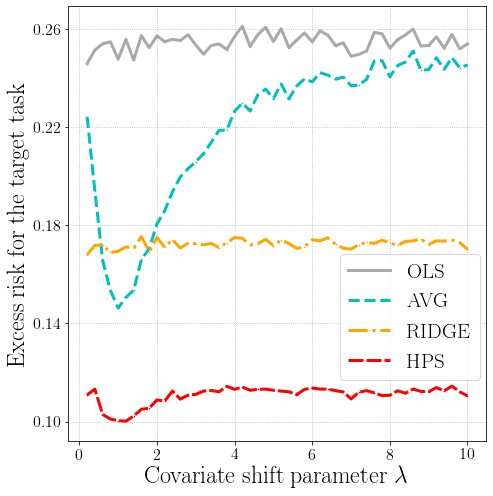

In [15]:
plt.figure(figsize=(7,7))

mean_stl2 = [np.mean(x) for x in STL_list2]
std_stl2 = [np.std(x) for x in STL_list2]
plt.errorbar(cov_shift_list2, mean_stl2, capthick=1, capsize=5, c='darkgrey', lw=3, marker='x', markersize=1,  label=r'$\mathrm{OLS}$')

mean_avg2 = [np.mean(x) for x in AVG_list2]
std_avg2 = [np.std(x) for x in AVG_list2]
plt.errorbar(cov_shift_list2, mean_avg2, capthick=1, capsize=5, c='c', lw=3, ls='dashed', marker='x', markersize=1,  label=r'$\mathrm{AVG}$')

mean_ridge2 = [np.mean(x) for x in ridge_list2]
std_ridge2 = [np.std(x) for x in ridge_list2]
plt.errorbar(cov_shift_list2, mean_ridge2, capthick=1, capsize=5, c='orange', lw=3, ls='dashdot', marker='x', markersize=1, label=r'$\mathrm{RIDGE}$')

mean_hps2 = [np.mean(x) for x in HPS_list2]
std_hps2 = [np.std(x) for x in HPS_list2]
plt.errorbar(cov_shift_list2, mean_hps2, capthick=1, capsize=5, c='r', lw=3, ls=(0, (5, 1)), marker='x', markersize=1,  label=r'$\mathrm{HPS}$')

#mean_tl = [np.mean(x) for x in TL_list]
#std_tl = [np.std(x) for x in TL_list]
#plt.errorbar(shift_list, mean_tl, yerr=std_tl, capthick=1, capsize=1, c='g', lw=1, marker='x', markersize=1,  label='TL')

plt.xlabel(r'$\mathrm{Covariate~shift~parameter}~\lambda$', fontsize=24)
plt.ylabel(r'$\mathrm{Excess~risk~for~the~target~task}$', fontsize=24)
#axes = plt.gca()
#axes.set_xlim([1.0, 20.0])

plt.yticks(np.arange(0.1, 0.28, 0.04), fontsize=16)
plt.xticks(fontsize=16)
#plt.xlim([500, 4000])
#plt.ylim([0.01, 2])

plt.grid(ls = ':', lw=0.8)
plt.legend(fontsize=21, loc=(0.65, 0.14))
plt.tight_layout()
plt.savefig('compare_risk_cov_model_shift.eps')